In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
import seaborn as sns
import collections

warnings.filterwarnings("ignore")
import re


In [41]:
df = pd.read_csv('train.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [84]:
# selecting numerical columns
numerical_columns = df.select_dtypes(include='number').drop(['id', 'scrape_id', 'host_id','latitude', 'longitude'], axis=1)
len(numerical_columns)
numerical_columns.columns

Index(['host_listings_count', 'host_total_listings_count', 'accommodates',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

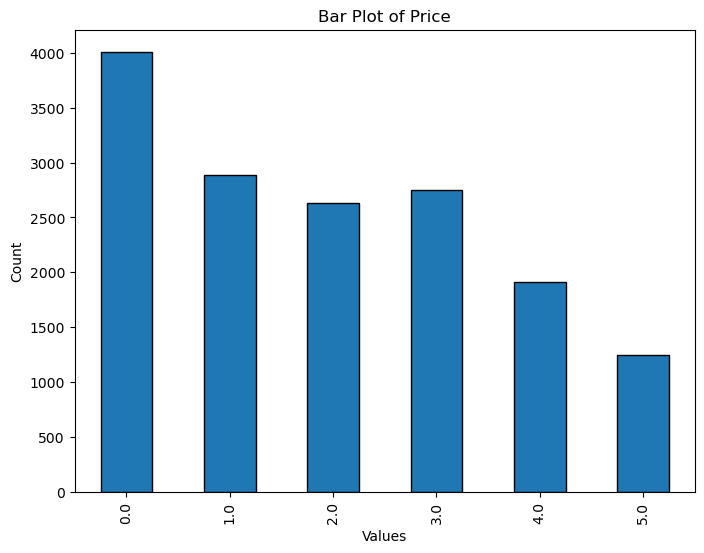

In [76]:
# Count the occurrences of each unique value in the column
value_counts = df['price'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
value_counts.sort_index().plot(kind='bar', edgecolor='black')  # Sort by index for better visualization
plt.title('Bar Plot of Price')
plt.xlabel('Values')
plt.ylabel('Count')
plt.show()

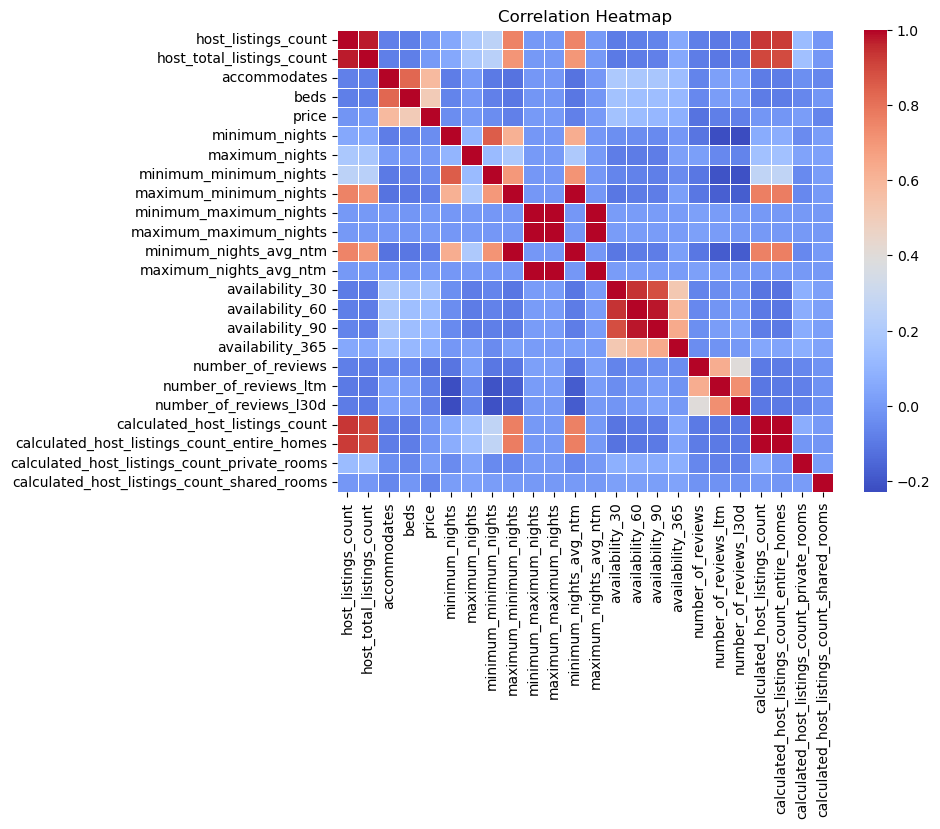

In [94]:
# Plot the heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_columns.corr(), annot=False, cmap='coolwarm', fmt=".6f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [44]:
# gets unique words for a column whose entries are lists
def get_unique_words(df, column_name):
    x = collections.Counter([y for x in df.loc[:,column_name].astype(str).values.flatten() for y in x.lower().replace('[', '').replace(']', '').replace(' ',"").replace('\'',"").replace('"',"").split(",")])
    return x

In [48]:
# finds a given keyword in a piece of text
def find_keyword(text, keyword, location=-2, length=1):
    index = text.find(keyword)
    if index == -1:
        return None
    try:
        return text[index + location:index + location + length]
    except:
        return None


In [49]:
# imputing missing ratings in the cleaned data using a Random Forest regressor
def fill_missing_ratings(df, features):
    # Identify rows with missing "ratings" values
    missing_ratings = df[df['ratings'].isna()]

    # Split the dataset
    train_set = df.dropna(subset=['ratings'])
    test_set = df[df['ratings'].isna()]
    print(train_set)
    print(test_set)

    # Train the submodel
    X_train = train_set[features]
    y_train = train_set['ratings']

    submodel = RandomForestRegressor(n_estimators=100, random_state=42)
    submodel.fit(X_train, y_train)

    # Predict ratings for the test set
    X_test = test_set[features]
    predicted_ratings = submodel.predict(X_test)

    # Fill in missing "ratings" values with predicted values
    df.loc[df['ratings'].isna(), 'ratings'] = predicted_ratings

    return df

In [121]:
# Cleans training data through extraction and feature engineering
def cleanData(df, test):

    ## Find Stars for Ratings
    df['ratings'] = df['name'].apply(lambda x: find_keyword(x, '\u2605', 1, 4))
    test['ratings'] = test['name'].apply(lambda x: find_keyword(x, '\u2605', 1, 4))

    # Create dummy columns for 'new' and 'none'
    df['new_rating'] = df['ratings'].apply(lambda x: 1 if x == 'New ' else 0)
    test['new_rating'] = test['ratings'].apply(lambda x: 1 if x == 'New ' else 0)

    # Convert continuous ratings to numeric, handling errors by setting them to NaN
    df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
    test['ratings'] = pd.to_numeric(test['ratings'], errors='coerce')

    # Create quintiles for continuous ratings and one-hot encode them
    # Separate NaN and non-NaN values
    non_nan_values = df['ratings'].dropna()

    # Create quintiles for non-NaN values
    quintiles, cutoffs = pd.qcut(non_nan_values, q=3, labels=False, retbins=True, precision=1)
    df.loc[~df['ratings'].isna(), 'quintile'] = pd.cut(non_nan_values, bins=cutoffs, labels=False)
    test.loc[~test['ratings'].isna(), 'quintile'] = pd.cut(non_nan_values, bins=cutoffs, labels=False)

    # Handle NaN values (assign NaN to quintile column)
    df.loc[df['ratings'].isna(), 'quintile'] = None
    test.loc[test['ratings'].isna(), 'quintile'] = None

    # Convert quintile column to integer type
    df['quintile'] = df['quintile'].astype(pd.Int64Dtype())
    test['quintile'] = test['quintile'].astype(pd.Int64Dtype())

    # Generate dummy variables
    df = pd.get_dummies(df, columns=['quintile'], prefix='rating', dummy_na=True)
    # df = df.drop("ratings", axis=1)
    test = pd.get_dummies(test, columns=['quintile'], prefix='rating', dummy_na=True)
    # test = test.drop("ratings", axis=1)

    ## Change Date for Host Since
    latest = pd.to_datetime(df['host_since']).sort_values().iloc[-1]
    df["host_days"] = (latest - pd.to_datetime(df['host_since'])).dt.days
    df = df.drop("host_since", axis=1)
    latest = pd.to_datetime(test['host_since']).sort_values().iloc[-1]
    test["host_days"] = (latest - pd.to_datetime(test['host_since'])).dt.days
    test = test.drop("host_since", axis=1)

    ## Find Bathrooms
    df["num_bathrooms"] = df['bathrooms_text'].astype(str).str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
    df = df.drop("bathrooms_text", axis=1)
    test["num_bathrooms"] = test['bathrooms_text'].astype(str).str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
    test = test.drop("bathrooms_text", axis=1)

    ## Find Bedrooms
    df["num_bedrooms"] = df['name'].apply(lambda x: find_keyword(x, 'bedroom')).astype(float)
    df = df.drop("name", axis=1)
    test["num_bedrooms"] = test['name'].apply(lambda x: find_keyword(x, 'bedroom')).astype(float)
    test = test.drop("name", axis=1)

    ## Categorise Amenities
    df["num_amenities"] = len(df["amenities"])
    amenities_list = get_unique_words(df, 'amenities').most_common(100)
    df['amenities'] = df['amenities'].astype('string')
    test['amenities'] = test['amenities'].astype('string')

    df['amenities'] = df['amenities'].apply(lambda x: x.lower().replace('[', '').replace(']', '').replace(' ', '').replace('"', ''))
    test['amenities'] = test['amenities'].apply(lambda x: x.lower().replace('[', '').replace(']', '').replace(' ', '').replace('"', ''))

    string_amenities = [amenity[0] for amenity in amenities_list if isinstance(amenity[0], str)]
    for amenity in string_amenities:
        df[amenity] = df['amenities'].apply(lambda x: 1 if amenity.lower() in x.lower() else 0)
        test[amenity] = test['amenities'].apply(lambda x: 1 if amenity.lower() in x.lower() else 0)
    df = df.drop("amenities", axis=1)
    test = test.drop("amenities", axis=1)

    # Categorise host verifications
    verif_list = ['email', 'phone', 'work_email']
    for verif in verif_list:
        df[verif] = df['host_verifications'].apply(lambda x: 1 if verif in x else 0)
        test[verif] = test['host_verifications'].apply(lambda x: 1 if verif in x else 0)
    df = df.drop("host_verifications", axis=1)
    test = test.drop("host_verifications", axis=1)

    # converting false and true to binary
    df.replace({'f': 0, 't': 1}, inplace=True)
    test.replace({'f': 0, 't': 1}, inplace=True)

    # dropping all useless variables
    to_drop = ["host_name", "host_id", 'scrape_id', 'last_scraped', 'description', 'picture_url','latitude',
       'longitude','calendar_last_scraped','calculated_host_listings_count', "host_listings_count", "maximum_minimum_nights"]
    df = df.drop(to_drop, axis=1)
    test = test.drop(to_drop, axis=1)

    ## dummify all categorical variables
    categorical_columns = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns, dummy_na=True)
    test = pd.get_dummies(test, columns=categorical_columns, prefix=categorical_columns, dummy_na=True)

    # Multiply the new columns with dummy variables
    property_type_df = df.filter(like="property_type")
    property_type_test = test.filter(like="property_type")
    df = pd.concat([df, (df["num_bedrooms"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_bed')], axis=1)
    test = pd.concat([test, (test["num_bedrooms"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_bed')], axis=1)
    df = pd.concat([df, (df["num_bathrooms"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_bath')], axis=1)
    test = pd.concat([test, (test["num_bathrooms"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_bath')], axis=1)
    df = pd.concat([df, (df["accommodates"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_acc')], axis=1)
    test = pd.concat([test, (test["accommodates"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_acc')], axis=1)

    # Multiply the new columns with dummy variables
    property_type_df = df.filter(like="room_type")
    property_type_test = test.filter(like="room_type")
    df = pd.concat([df, (df["num_bedrooms"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_bed')], axis=1)
    test = pd.concat([test, (test["num_bedrooms"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_bed')], axis=1)
    df = pd.concat([df, (df["num_bathrooms"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_bath')], axis=1)
    test = pd.concat([test, (test["num_bathrooms"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_bath')], axis=1)
    df = pd.concat([df, (df["accommodates"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_acc')], axis=1)
    test = pd.concat([test, (test["accommodates"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_acc')], axis=1)

    rating_type_df = df.filter(like="room_type")
    rating_type_test = test.filter(like="room_type")
    df = pd.concat([df, (df["availability_30"].to_numpy().reshape(-1, 1) * rating_type_df).add_suffix('_avail30')], axis=1)
    test = pd.concat([test, (test["availability_30"].to_numpy().reshape(-1, 1) * rating_type_test).add_suffix('_avail30')], axis=1)
    df = pd.concat([df, (df["availability_60"].to_numpy().reshape(-1, 1) * rating_type_df).add_suffix('_avail60')], axis=1)
    test = pd.concat([test, (test["availability_60"].to_numpy().reshape(-1, 1) * rating_type_test).add_suffix('_avail60')], axis=1)
    df = pd.concat([df, (df["availability_365"].to_numpy().reshape(-1, 1) * rating_type_df).add_suffix('_avail365')], axis=1)
    test = pd.concat([test, (test["availability_365"].to_numpy().reshape(-1, 1) * rating_type_test).add_suffix('_avail365')], axis=1)
    df = pd.concat([df, (df["availability_90"].to_numpy().reshape(-1, 1) * rating_type_df).add_suffix('_avail90')], axis=1)
    test = pd.concat([test, (test["availability_90"].to_numpy().reshape(-1, 1) * rating_type_test).add_suffix('_avail90')], axis=1)


    #adding bed * bath
    df['bed_bath_product'] = df['num_bathrooms'] * df['num_bedrooms']
    test['bed_bath_product'] = test['num_bathrooms'] * test['num_bedrooms']
    # Calculate 'bed_bath_quot' and handle division by zero
    df['bed_bath_quot'] = np.where(df['num_bedrooms'] != 0, df['num_bathrooms'] / df['num_bedrooms'], np.nan)
    test['bed_bath_quot'] = np.where(test['num_bedrooms'] != 0, test['num_bathrooms'] / test['num_bedrooms'], np.nan)

    # Calculate 'bed_acc_quot' and handle division by zero
    df['bed_acc_quot'] = np.where(df['accommodates'] != 0, df['num_bathrooms'] / df['accommodates'], np.nan)
    test['bed_acc_quot'] = np.where(test['accommodates'] != 0, test['num_bathrooms'] / test['accommodates'], np.nan)
    # df['bed_bath_room_product'] = df['num_bathrooms'] * df['num_bedrooms'] * df['beds']
    # test['bed_bath_room_product'] = test['num_bathrooms'] * test['num_bedrooms'] * test['beds']
    df['bed_bath_acc_product'] = df['num_bathrooms'] * df['num_bedrooms'] * df['accommodates']
    test['bed_bath_acc_product'] = test['num_bathrooms'] * test['num_bedrooms'] * df['accommodates']
    df['host_days_acc'] = df['host_days'] * df['accommodates']
    test['host_days_acc'] = test['host_days'] * df['accommodates']

    property_type_df = df.filter(like="availability")
    property_type_test = test.filter(like="availability")
    df = pd.concat([df, (df["bed_bath_product"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_bedbath')], axis=1)
    test = pd.concat([test, (test["bed_bath_product"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_bedbath')], axis=1)
    df = pd.concat([df, (df["accommodates"].to_numpy().reshape(-1, 1) * property_type_df).add_suffix('_acc')], axis=1)
    test = pd.concat([test, (test["accommodates"].to_numpy().reshape(-1, 1) * property_type_test).add_suffix('_acc')], axis=1)

    df.rename(columns={'rating_<NA>': 'none_rating'}, inplace=True)
    test.rename(columns={'rating_<NA>': 'none_rating'}, inplace=True)
    
    # Initialize KNNImputer with the desired number of neighbors (k)
    knn_imputer = KNNImputer(n_neighbors=5)

    # Impute missing values in the DataFrame
    imputed_data = knn_imputer.fit_transform(df)
    # Convert the imputed data back to a DataFrame
    df = pd.DataFrame(imputed_data, columns=df.columns)

    # Impute missing values in the DataFrame
    imputed_test = knn_imputer.fit_transform(test)
    # Convert the imputed data back to a DataFrame
    test = pd.DataFrame(imputed_test, columns=test.columns)

    df, test = df.align(test, axis=1, fill_value=0)
    
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns.difference(['price','id'])

    # Min-max scale numerical columns
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    test[numerical_columns] = scaler.fit_transform(test[numerical_columns])

    
    test = test.drop("price", axis=1)
    return df, test

In [122]:
cleaned_train, cleaned_test = cleanData(train, test)

In [123]:
cleaned_train.to_csv("cleaned_train.csv", index=False)
cleaned_test.to_csv("cleaned_test.csv", index=False)